# Threshold Analysis: Delta vs SIRS Proportions

This notebook visualizes the relationship between the delta parameter (recovered duration) and the average proportions of Susceptible, Infected, and Recovered fish at equilibrium.

In [95]:
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

## Replicate Infection Probability Regression

In equation **S3** the authors give the probability that an individual $i$ startles given that individual $j$ has startled. I substitute their $\beta_n$ for $\alpha_n$ for clarity against SIRS.

$$
P(s_i | s_j) = \dfrac{1}{1+e^{-\alpha_1-\alpha_2 LMD - \alpha_3 RAA}}
$$

- *LMD* is the log of the metric distance between the two fish
- *RAA* is the ranked angular area of fish $j$ (compared to other fish) on the retina of fish $i$.

Authors fit a logistic regression model to the entire dataset and find coefficients
- $\alpha_1=0.06449$
- $\alpha_2=−3.20552$
- $\alpha_3=−0.08016$.

I will try to replicate this regression.

In [96]:
# Read the CSV into dataframe
csv_path = "realdata/first_responders_srk1.csv"
df = pd.read_csv(csv_path)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14490 entries, 0 to 14489
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Trial             14490 non-null  object 
 1   Event_raw         14490 non-null  int64  
 2   Event_trial       14490 non-null  int64  
 3   Response          14490 non-null  int64  
 4   Resp_Int          14490 non-null  float64
 5   Initiator         14490 non-null  float64
 6   Log_Init          14490 non-null  float64
 7   When              14490 non-null  object 
 8   Class             14490 non-null  object 
 9   Dist_metric       14490 non-null  float64
 10  Log_dist_metric   14490 non-null  float64
 11  Dist_topological  14490 non-null  int64  
 12  Ang_area          14490 non-null  float64
 13  Rank_area         14490 non-null  int64  
 14  Loom              14490 non-null  float64
 15  Log_loom          14490 non-null  float64
 16  Ang_pos           14490 non-null  float6

This code block - written by Claude - attempts to recreate the coefficients the authors find in the last paragraph of Section 6.1.

There is a difference in the author's values compared to what I could find. I think that's due to the simplification of omitting the higher order terms in equation **S7**. But they say that for small cascades they are very small, so this works out.

In [97]:
# Fit the logistic regression model, to verify author's findings
# Targeting the PARAGRAPH values for first exposure (combining Before+After)
# Target: Intercept=0.06449, Log_dist_metric=-3.20552, Rank_area=-0.08016

# Try different data filters to match author's approach
X1 = df[["Log_dist_metric", "Rank_area"]]
y1 = df["Response"]
X1_const = sm.add_constant(X1)

logit1 = sm.Logit(y1, X1_const)
result1 = logit1.fit(disp=0)

# Try filtering for Schreckstoff only
df_schreck = df[df["Class"] == "Schreck"].copy()
X2 = df_schreck[["Log_dist_metric", "Rank_area"]]
y2 = df_schreck["Response"]
X2_const = sm.add_constant(X2)

logit2 = sm.Logit(y2, X2_const)
result2 = logit2.fit(disp=0)

# Try Water control only
df_water = df[df["Class"] == "Water"].copy()
X3 = df_water[["Log_dist_metric", "Rank_area"]]
y3 = df_water["Response"]
X3_const = sm.add_constant(X3)

logit3 = sm.Logit(y3, X3_const)
result3 = logit3.fit(disp=0)

# Try only After Schreckstoff
df_after_schreck = df[(df["When"] == "After") & (df["Class"] == "Schreck")].copy()
X4 = df_after_schreck[["Log_dist_metric", "Rank_area"]]
y4 = df_after_schreck["Response"]
X4_const = sm.add_constant(X4)

logit4 = sm.Logit(y4, X4_const)
result4 = logit4.fit(disp=0)

# Try Before+After Water (baseline)
df_water_both = df[df["Class"] == "Water"].copy()
X5 = df_water_both[["Log_dist_metric", "Rank_area"]]
y5 = df_water_both["Response"]
X5_const = sm.add_constant(X5)

logit5 = sm.Logit(y5, X5_const)
result5 = logit5.fit(disp=0)

# Summary comparison
print("\n" + "=" * 80)
print("SUMMARY COMPARISON")
print("=" * 80)

comparison = pd.DataFrame(
    {
        "Data Filter": [
            "Authors (Paragraph)",
            "All data",
            "Schreck only",
            "Water only",
            "After+Schreck",
            "Water (Before+After)",
        ],
        "Intercept": [
            0.06449,
            result1.params["const"],
            result2.params["const"],
            result3.params["const"],
            result4.params["const"],
            result5.params["const"],
        ],
        "Log_dist_metric": [
            -3.20552,
            result1.params["Log_dist_metric"],
            result2.params["Log_dist_metric"],
            result3.params["Log_dist_metric"],
            result4.params["Log_dist_metric"],
            result5.params["Log_dist_metric"],
        ],
        "Rank_area": [
            -0.08016,
            result1.params["Rank_area"],
            result2.params["Rank_area"],
            result3.params["Rank_area"],
            result4.params["Rank_area"],
            result5.params["Rank_area"],
        ],
    }
)

print("\n", comparison.to_string(index=False))

# Find closest match
diffs = []
for i in range(1, 6):
    diff = (
        abs(comparison.iloc[i]["Intercept"] - 0.06449)
        + abs(comparison.iloc[i]["Log_dist_metric"] - (-3.20552))
        + abs(comparison.iloc[i]["Rank_area"] - (-0.08016))
    )
    diffs.append(diff)

best_idx = diffs.index(min(diffs)) + 1
print(f"\n\nBest match: {comparison.iloc[best_idx]['Data Filter']}")
print(f"Total absolute difference: {min(diffs):.4f}")


SUMMARY COMPARISON

          Data Filter  Intercept  Log_dist_metric  Rank_area
 Authors (Paragraph)   0.064490        -3.205520  -0.080160
            All data  -0.143799        -2.919403  -0.090306
        Schreck only   0.103641        -3.297823  -0.075034
          Water only  -1.163007        -1.688313  -0.142336
       After+Schreck   0.319212        -3.639221  -0.062179
Water (Before+After)  -1.163007        -1.688313  -0.142336


Best match: Schreck only
Total absolute difference: 0.1366


### Parameters I use

According to the logistic regression above, I will use the logistic regression:

$$
P(s_i | s_j) = \dfrac{1}{1+e^{-\alpha_1-\alpha_2 LMD - \alpha_3 RAA}}
$$

- $\alpha_1 = 0.103641$
- $\alpha_2 = -3.297823$
- $\alpha_3 = -0.075034$

This yields the following plot, overlaid with startles from the dataset.

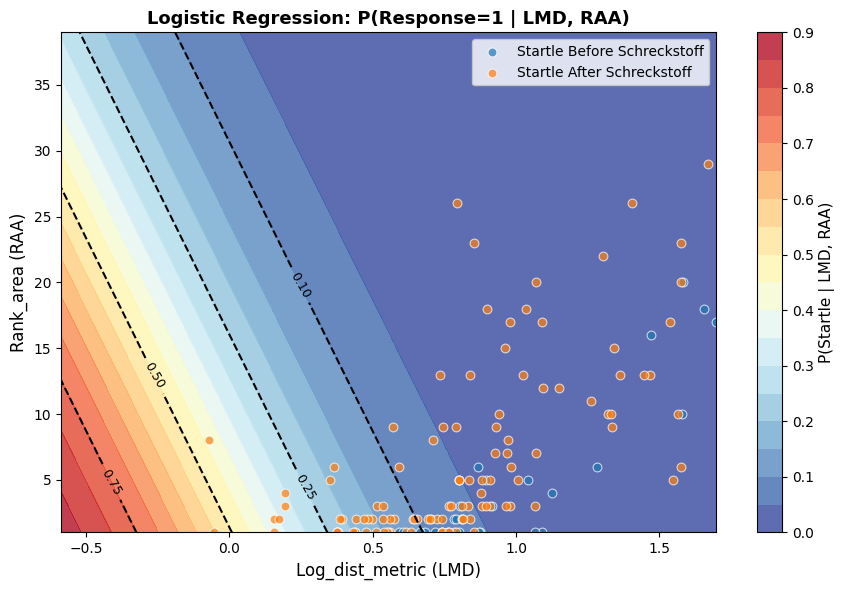

In [98]:
# Plot learned logistic regression for LMD and RAA

import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Use the Schreck-only dataset (the selected model)
df_plot = df_schreck.copy()

# Create a mesh grid over the feature space
log_dist_range = np.linspace(
    df_plot["Log_dist_metric"].min(), df_plot["Log_dist_metric"].max(), 100
)
rank_area_range = np.linspace(
    df_plot["Rank_area"].min(), df_plot["Rank_area"].max(), 100
)
log_dist_mesh, rank_area_mesh = np.meshgrid(log_dist_range, rank_area_range)

# Get the fitted coefficients from result2 (Schreck only)
beta_1 = result2.params["const"]
beta_2 = result2.params["Log_dist_metric"]
beta_3 = result2.params["Rank_area"]

# Calculate probability surface: P = 1 / (1 + exp(-beta_1 - beta_2*LMD - beta_3*RAA))
logit = beta_1 + beta_2 * log_dist_mesh + beta_3 * rank_area_mesh
prob_mesh = 1 / (1 + np.exp(-logit))

fig2, ax2 = plt.subplots(figsize=(9, 6))

# Create contour plot
contour = ax2.contourf(
    log_dist_mesh, rank_area_mesh, prob_mesh, levels=20, cmap="RdYlBu_r", alpha=0.8
)
contour_lines = ax2.contour(
    log_dist_mesh,
    rank_area_mesh,
    prob_mesh,
    levels=[0.1, 0.25, 0.5, 0.75, 0.9],
    colors="black",
    linewidths=1.5,
    linestyles="--",
)
ax2.clabel(contour_lines, inline=True, fontsize=9, fmt="%.2f")

# Separate Response=1 (rare) and Response=0 (common)
df_response1 = df_plot[df_plot["Response"] == 1]
df_response0 = df_plot[df_plot["Response"] == 0]
# Overlay actual Response=1 data points
response1_before = df_response1[df_response1["When"] == "Before"]
response1_after = df_response1[df_response1["When"] == "After"]
ax2.scatter(
    response1_before["Log_dist_metric"],
    response1_before["Rank_area"],
    marker="o",
    s=40,
    alpha=0.7,
    edgecolors="white",
    linewidths=0.8,
    label="Startle Before Schreckstoff",
)
ax2.scatter(
    response1_after["Log_dist_metric"],
    response1_after["Rank_area"],
    marker="o",
    s=40,
    alpha=0.7,
    edgecolors="white",
    linewidths=0.8,
    label="Startle After Schreckstoff",
)

ax2.set_xlabel("Log_dist_metric (LMD)", fontsize=12)
ax2.set_ylabel("Rank_area (RAA)", fontsize=12)
ax2.set_title(
    "Logistic Regression: P(Response=1 | LMD, RAA)", fontsize=13, fontweight="bold"
)
ax2.legend(loc="best")

# Add colorbar
cbar = plt.colorbar(contour, ax=ax2)
cbar.set_label("P(Startle | LMD, RAA)", fontsize=11)

plt.tight_layout()
plt.show()

## Empirical Nearest Neighbor Distances: Scared vs Relaxed States to Inform Couzin Model

The `NND_data.h5` file contains nearest neighbor distance measurements for fish under two conditions:
- **Schreck (scared)**: Fish exposed to schreckstoff (alarm hormone) - tight formation
- **Water (relaxed)**: Water control - loose formation

These measurements inform the Couzin model zone parameters for simulating scared vs relaxed schooling behavior.

I take the median nearest neighbor distance across 500 frames after the injection of water or Schreckstoff into the tank.

In [99]:
# Load empirical nearest neighbor distance (NND) data
with h5py.File("realdata/NND_data.h5", "r") as f:
    schreck_data = f["schreck_1st"][:]  # Schreckstoff (alarm hormone) - scared state
    water_data = f["water_1st"][:]  # Water control - relaxed state

# Replace any zero with NaN
schreck_nnd = np.where(schreck_data == 0, np.nan, schreck_data)
water_nnd = np.where(water_data == 0, np.nan, water_data)

# Get median distance of all fish in all frames of all trials, ignoring NaN
schreck_median_nnd = np.nanmedian(schreck_nnd[2000:2500, :, :])
water_median_nnd = np.nanmedian(water_nnd[2000:2500, :, :])
print(f"Median Schreckstoff nearest neighbor distance: {schreck_median_nnd:.2f} cm")
print(f"Median water nearest neighbor distance: {water_median_nnd:.2f} cm")

print(f"\nComparison:")
print(f"  Ratio (relaxed/scared): {water_median_nnd/schreck_median_nnd:.2f}x")
print(f"  Scared fish swim {(1 - schreck_median_nnd/water_median_nnd)*100:.1f}% closer")
print(
    f"  Relaxed fish swim {(water_median_nnd/schreck_median_nnd - 1)*100:.1f}% farther apart"
)

Median Schreckstoff nearest neighbor distance: 3.54 cm
Median water nearest neighbor distance: 6.01 cm

Comparison:
  Ratio (relaxed/scared): 1.70x
  Scared fish swim 41.2% closer
  Relaxed fish swim 70.0% farther apart


### Fitting Couzin Zone Parameters to Target NND Values

We want to find the right `zone_repulsion` and `zone_attraction` parameters to match empirical nearest neighbor distances (NND):
- **Relaxed state (water control)**: Target NND ≈ 6.0 cm
- **Alarmed state (schreckstoff)**: Target NND ≈ 3.5 cm

We'll test different parameter combinations by running simulations without predators and measuring the steady-state NND at frame 400.

In [100]:
import sys

sys.path.insert(0, "..")  # Add parent directory to path
from fish_school_simulator import run_simulation
import numpy as np

# Target NND values from empirical data
TARGET_RELAXED_NND = 6.0  # cm (water control)
TARGET_ALARMED_NND = 3.5  # cm (schreckstoff)

# Parameter sets to test
# Note: zone_orientation and zone_attraction maintain 4x and 8x ratios relative to zone_repulsion
test_configs = [
    {
        "name": "Relaxed: repulsion=5, orientation=12, attraction=36",
        "zone_repulsion": 5.0,
        "zone_orientation": 12.0,
        "zone_attraction": 36.0,
        "target_nnd": TARGET_RELAXED_NND,
        "state": "relaxed",
    },
    {
        "name": "Alarmed: repulsion=2.75, orientation=12, attraction=48",
        "zone_repulsion": 2.75,
        "zone_orientation": 12.0,
        "zone_attraction": 48.0,
        "target_nnd": TARGET_ALARMED_NND,
        "state": "alarmed",
    },
]

print("=" * 80)
print("TESTING COUZIN ZONE PARAMETERS FOR TARGET NND VALUES")
print("=" * 80)
print(f"\nTarget NND - Relaxed state (water): {TARGET_RELAXED_NND:.2f} cm")
print(f"Target NND - Alarmed state (schreck): {TARGET_ALARMED_NND:.2f} cm")
print(f"\nRunning 10 simulations per configuration...")
print("Each simulation: 40 fish, 400 frames, NO predator\n")

results = []

for config in test_configs:
    nnd_values = []

    # Run 10 simulations
    for trial in range(10):
        # Run simulation without predator (set spawn frame beyond simulation length)
        school = run_simulation(
            n_fish=40,
            n_steps=400,
            predator_spawn_frame=9999,  # Never spawn predator
            gamma=10,
            delta=20,
            space_size=(100, 200, 100),  # Tank dimensions
            zone_repulsion=config["zone_repulsion"],
            zone_orientation=config["zone_orientation"],
            zone_attraction=config["zone_attraction"],
            verbose=False,
        )

        # Calculate average NND at frame 400
        avg_nnd = school.get_average_nearest_neighbor_distance()
        nnd_values.append(avg_nnd)

    # Calculate statistics
    mean_nnd = np.mean(nnd_values)
    std_nnd = np.std(nnd_values)
    min_nnd = np.min(nnd_values)
    max_nnd = np.max(nnd_values)
    error = abs(mean_nnd - config["target_nnd"])

    results.append(
        {
            "config": config["name"],
            "state": config["state"],
            "zone_repulsion": config["zone_repulsion"],
            "zone_attraction": config["zone_attraction"],
            "target_nnd": config["target_nnd"],
            "mean_nnd": mean_nnd,
            "std_nnd": std_nnd,
            "min_nnd": min_nnd,
            "max_nnd": max_nnd,
            "error": error,
            "nnd_values": nnd_values,
        }
    )

# Summary table
print("\n\n" + "=" * 80)
print("SUMMARY - All Configurations")
print("=" * 80)
print(
    f"{'Configuration':<40} {'Mean NND':<12} {'Target':<10} {'Error':<10} {'Error %':<10}"
)
print("-" * 80)

for r in results:
    error_pct = r["error"] / r["target_nnd"] * 100
    print(
        f"{r['config']:<40} {r['mean_nnd']:>6.2f} ± {r['std_nnd']:<4.2f} {r['target_nnd']:>6.2f}    {r['error']:>6.2f}    {error_pct:>6.1f}%"
    )

print("=" * 80)

# Find best configuration for each state
relaxed_results = [r for r in results if r["state"] == "relaxed"]
alarmed_results = [r for r in results if r["state"] == "alarmed"]

if relaxed_results:
    best_relaxed = min(relaxed_results, key=lambda x: x["error"])
    print(f"\nBest for RELAXED state: {best_relaxed['config']}")
    print(
        f"  Mean NND: {best_relaxed['mean_nnd']:.2f} cm (target: {best_relaxed['target_nnd']:.2f} cm)"
    )
    print(
        f"  Parameters: repulsion={best_relaxed['zone_repulsion']}, attraction={best_relaxed['zone_attraction']}"
    )

if alarmed_results:
    best_alarmed = min(alarmed_results, key=lambda x: x["error"])
    print(f"\nBest for ALARMED state: {best_alarmed['config']}")
    print(
        f"  Mean NND: {best_alarmed['mean_nnd']:.2f} cm (target: {best_alarmed['target_nnd']:.2f} cm)"
    )
    print(
        f"  Parameters: repulsion={best_alarmed['zone_repulsion']}, attraction={best_alarmed['zone_attraction']}"
    )

TESTING COUZIN ZONE PARAMETERS FOR TARGET NND VALUES

Target NND - Relaxed state (water): 6.00 cm
Target NND - Alarmed state (schreck): 3.50 cm

Running 10 simulations per configuration...
Each simulation: 40 fish, 400 frames, NO predator



SUMMARY - All Configurations
Configuration                            Mean NND     Target     Error      Error %   
--------------------------------------------------------------------------------
Relaxed: repulsion=5, orientation=12, attraction=36   6.49 ± 1.18   6.00      0.49       8.2%
Alarmed: repulsion=2.75, orientation=12, attraction=48   3.47 ± 0.25   3.50      0.03       0.7%

Best for RELAXED state: Relaxed: repulsion=5, orientation=12, attraction=36
  Mean NND: 6.49 cm (target: 6.00 cm)
  Parameters: repulsion=5.0, attraction=36.0

Best for ALARMED state: Alarmed: repulsion=2.75, orientation=12, attraction=48
  Mean NND: 3.47 cm (target: 3.50 cm)
  Parameters: repulsion=2.75, attraction=48.0


## Analyzing Delta Threshold

This section finds the threshold $\delta$ value for disease-free vs. endemic equilibrium.
The key question: **What is the probability that the system settles into an endemic equilibrium (I > 0) vs a disease-free equilibrium (I ≈ 0)?**

In [101]:
# Load detailed trial-by-trial results
detailed = pd.read_csv("threshold_relaxed_detailed_results.csv")
print(f"Loaded {len(detailed)} trial results")
print(f"Delta values: {detailed['delta'].nunique()} unique values")
print(f"Trials per delta: {len(detailed) // detailed['delta'].nunique()}")
detailed.head()

Loaded 5250 trial results
Delta values: 21 unique values
Trials per delta: 250


,delta,trial,S_count,I_count,R_count,S_proportion,I_proportion,R_proportion,nnd_before_predator
0,0.0,11,40,0,0,1.000,0.000,0.000,6.682491
1,0.0,4,10,29,1,0.250,0.725,0.025,8.076773
2,0.0,9,9,27,4,0.225,0.675,0.100,7.541278
3,0.0,7,8,27,5,0.200,0.675,0.125,9.503597
4,0.0,6,13,26,1,0.325,0.650,0.025,6.215002


In [102]:
# Calculate summary statistics for RELAXED state
summary_relaxed = detailed.groupby("delta").agg(
    {
        "S_proportion": ["mean", "std"],
        "I_proportion": ["mean", "std"],
        "R_proportion": ["mean", "std"],
    }
)

# Extract arrays for plotting
delta_values = summary_relaxed.index.values
s_mean_relaxed = summary_relaxed["S_proportion"]["mean"].values
s_std_relaxed = summary_relaxed["S_proportion"]["std"].values
i_mean_relaxed = summary_relaxed["I_proportion"]["mean"].values
i_std_relaxed = summary_relaxed["I_proportion"]["std"].values
r_mean_relaxed = summary_relaxed["R_proportion"]["mean"].values
r_std_relaxed = summary_relaxed["R_proportion"]["std"].values

# For backward compatibility with existing plots that use delta_values, s_mean, etc.
s_mean = s_mean_relaxed
s_std = s_std_relaxed
i_mean = i_mean_relaxed
i_std = i_std_relaxed
r_mean = r_mean_relaxed
r_std = r_std_relaxed

print("Relaxed state summary statistics calculated")

Relaxed state summary statistics calculated


In [103]:
# Load ALARMED state detailed trial-by-trial results
detailed_alarmed = pd.read_csv("threshold_alarmed_detailed_results.csv")
print(f"Loaded {len(detailed_alarmed)} ALARMED trial results")
print(f"Delta values: {detailed_alarmed['delta'].nunique()} unique values")
print(
    f"Trials per delta: {len(detailed_alarmed) // detailed_alarmed['delta'].nunique()}"
)

# Calculate summary statistics for ALARMED state
summary_alarmed = detailed_alarmed.groupby("delta").agg(
    {
        "S_proportion": ["mean", "std"],
        "I_proportion": ["mean", "std"],
        "R_proportion": ["mean", "std"],
    }
)

# Extract arrays for plotting
s_mean_alarmed = summary_alarmed["S_proportion"]["mean"].values
s_std_alarmed = summary_alarmed["S_proportion"]["std"].values
i_mean_alarmed = summary_alarmed["I_proportion"]["mean"].values
i_std_alarmed = summary_alarmed["I_proportion"]["std"].values
r_mean_alarmed = summary_alarmed["R_proportion"]["mean"].values
r_std_alarmed = summary_alarmed["R_proportion"]["std"].values

print("Alarmed state summary statistics calculated")

Loaded 5250 ALARMED trial results
Delta values: 21 unique values
Trials per delta: 250
Alarmed state summary statistics calculated


In [104]:
# Define threshold for endemic equilibrium
# More than 1 fish infected out of 40 total fish
ENDEMIC_THRESHOLD = 1 / 40

# Calculate probability of endemic equilibrium for each delta (RELAXED state)
endemic_prob_series = detailed.groupby("delta", observed=False).apply(
    lambda x: (x["I_proportion"] > ENDEMIC_THRESHOLD).sum() / len(x),
    include_groups=False,
)

# Extract delta values and probabilities in matching order
delta_values_bifurcation = endemic_prob_series.index.values
endemic_probs = endemic_prob_series.values

# Probability of disease-free equilibrium
disease_free_probs = 1 - endemic_probs

print(f"RELAXED State:")
print(
    f"  Endemic probability range: {endemic_probs.min():.2%} to {endemic_probs.max():.2%}"
)
print(
    f"  Disease-free probability range: {disease_free_probs.min():.2%} to {disease_free_probs.max():.2%}"
)
print(
    f"  Delta values for bifurcation analysis: {len(delta_values_bifurcation)} points"
)

RELAXED State:
  Endemic probability range: 0.80% to 96.40%
  Disease-free probability range: 3.60% to 99.20%
  Delta values for bifurcation analysis: 21 points


In [105]:
# Calculate probability of endemic equilibrium for ALARMED state
endemic_prob_series_alarmed = detailed_alarmed.groupby("delta", observed=False).apply(
    lambda x: (x["I_proportion"] > ENDEMIC_THRESHOLD).sum() / len(x),
    include_groups=False,
)

# Extract delta values and probabilities for alarmed state
endemic_probs_alarmed = endemic_prob_series_alarmed.values
disease_free_probs_alarmed = 1 - endemic_probs_alarmed

print(
    f"ALARMED State - Endemic probability range: {endemic_probs_alarmed.min():.2%} to {endemic_probs_alarmed.max():.2%}"
)
print(
    f"ALARMED State - Disease-free probability range: {disease_free_probs_alarmed.min():.2%} to {disease_free_probs_alarmed.max():.2%}"
)

ALARMED State - Endemic probability range: 0.00% to 99.20%
ALARMED State - Disease-free probability range: 0.80% to 100.00%


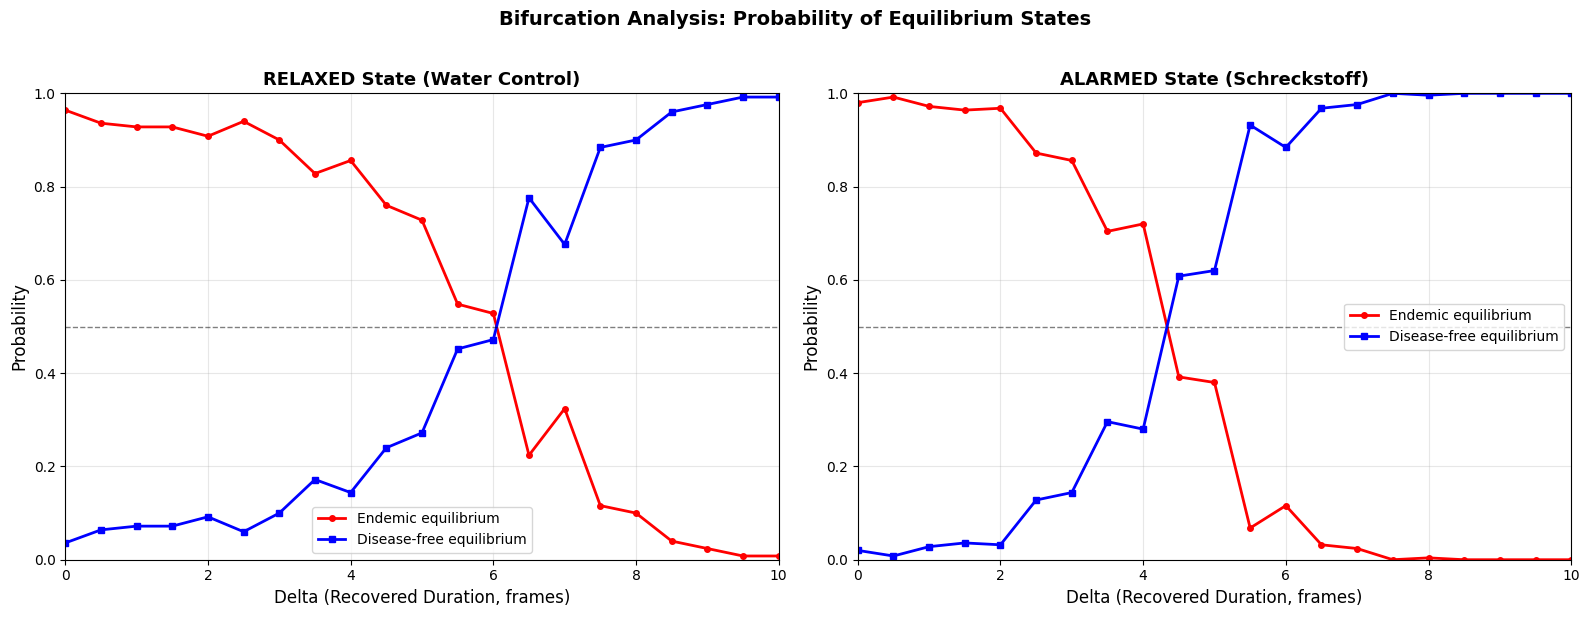

In [106]:
# Create side-by-side bifurcation plots for Relaxed vs Alarmed states
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: RELAXED state (water control - loose formation)
ax1.plot(
    delta_values_bifurcation,
    endemic_probs,
    "r-",
    linewidth=2,
    marker="o",
    markersize=4,
    label="Endemic equilibrium",
)
ax1.plot(
    delta_values_bifurcation,
    disease_free_probs,
    "b-",
    linewidth=2,
    marker="s",
    markersize=4,
    label="Disease-free equilibrium",
)
ax1.axhline(y=0.5, color="k", linestyle="--", linewidth=1, alpha=0.5)
ax1.set_xlabel("Delta (Recovered Duration, frames)", fontsize=12)
ax1.set_ylabel("Probability", fontsize=12)
ax1.set_title("RELAXED State (Water Control)", fontsize=13, fontweight="bold")
ax1.legend(fontsize=10, loc="best")
ax1.grid(True, alpha=0.3)
ax1.set_xlim(delta_values_bifurcation[0], delta_values_bifurcation[-1])
ax1.set_ylim(0, 1)

# Right plot: ALARMED state (schreckstoff - tight formation)
ax2.plot(
    delta_values_bifurcation,
    endemic_probs_alarmed,
    "r-",
    linewidth=2,
    marker="o",
    markersize=4,
    label="Endemic equilibrium",
)
ax2.plot(
    delta_values_bifurcation,
    disease_free_probs_alarmed,
    "b-",
    linewidth=2,
    marker="s",
    markersize=4,
    label="Disease-free equilibrium",
)
ax2.axhline(y=0.5, color="k", linestyle="--", linewidth=1, alpha=0.5)
ax2.set_xlabel("Delta (Recovered Duration, frames)", fontsize=12)
ax2.set_ylabel("Probability", fontsize=12)
ax2.set_title("ALARMED State (Schreckstoff)", fontsize=13, fontweight="bold")
ax2.legend(fontsize=10, loc="best")
ax2.grid(True, alpha=0.3)
ax2.set_xlim(delta_values_bifurcation[0], delta_values_bifurcation[-1])
ax2.set_ylim(0, 1)

plt.suptitle(
    "Bifurcation Analysis: Probability of Equilibrium States",
    fontsize=14,
    fontweight="bold",
    y=1.02,
)
plt.tight_layout()
plt.show()

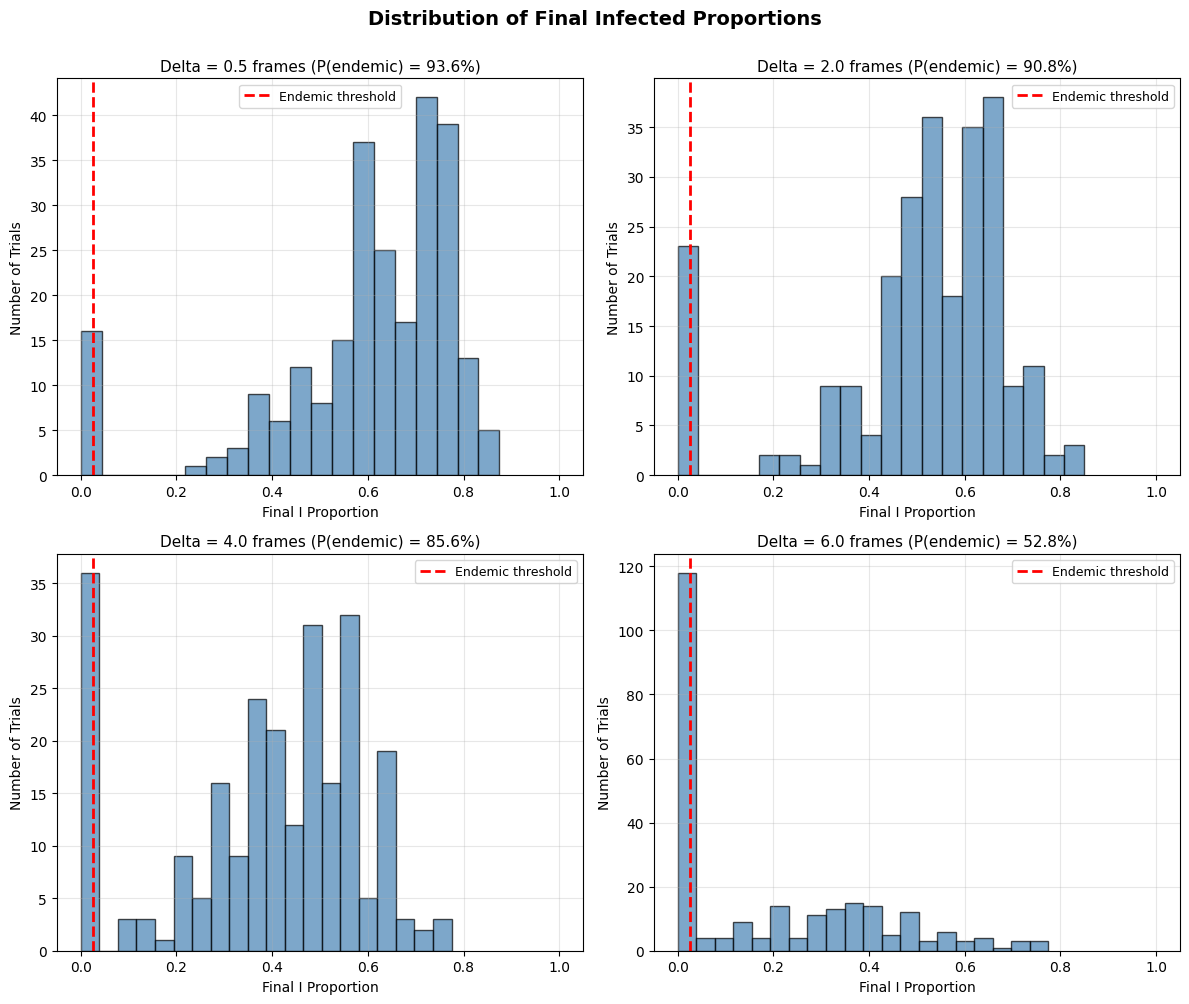

In [107]:
# Distribution analysis: Show histograms for selected delta values
key_deltas_dist = [0.5, 2.0, 4.0, 6.0]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, delta in enumerate(key_deltas_dist):
    ax = axes[i]
    data = detailed[detailed["delta"] == delta]["I_proportion"]

    # Calculate statistics
    n_endemic = (data > ENDEMIC_THRESHOLD).sum()
    n_total = len(data)
    p_endemic = n_endemic / n_total

    ax.hist(data, bins=20, edgecolor="black", alpha=0.7, color="steelblue")
    ax.axvline(
        ENDEMIC_THRESHOLD,
        color="r",
        linestyle="--",
        linewidth=2,
        label="Endemic threshold",
    )
    ax.set_xlabel("Final I Proportion", fontsize=10)
    ax.set_ylabel("Number of Trials", fontsize=10)
    ax.set_title(
        f"Delta = {delta:.1f} frames (P(endemic) = {p_endemic:.1%})", fontsize=11
    )
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(-0.05, 1.05)

plt.suptitle(
    "Distribution of Final Infected Proportions", fontsize=14, fontweight="bold", y=1.00
)
plt.tight_layout()
plt.show()

In [108]:
# Find critical delta where P(endemic) crosses 50%
crossing_indices = np.where(np.diff(np.sign(endemic_probs - 0.5)))[0]

if len(crossing_indices) > 0:
    idx = crossing_indices[0]
    critical_delta_lower = delta_values_bifurcation[idx]
    critical_delta_upper = delta_values_bifurcation[idx + 1]

    print("=" * 60)
    print("CRITICAL DELTA THRESHOLD ANALYSIS")
    print("=" * 60)
    print(f"\nTransition from endemic to disease-free occurs between:")
    print(
        f"  Delta = {critical_delta_lower:.2f}: P(endemic) = {endemic_probs[idx]:.1%}"
    )
    print(
        f"  Delta = {critical_delta_upper:.2f}: P(endemic) = {endemic_probs[idx+1]:.1%}"
    )

    # Linear interpolation to estimate 50% crossing point
    if endemic_probs[idx] != endemic_probs[idx + 1]:
        critical_delta_est = critical_delta_lower + (0.5 - endemic_probs[idx]) * (
            critical_delta_upper - critical_delta_lower
        ) / (endemic_probs[idx + 1] - endemic_probs[idx])
        print(f"\nEstimated 50% threshold: Delta ≈ {critical_delta_est:.2f} frames")

    # Show a few delta values around the transition
    print(f"\nProbabilities around transition:")
    for i in range(max(0, idx - 2), min(len(delta_values_bifurcation), idx + 4)):
        print(
            f"  Delta = {delta_values_bifurcation[i]:5.1f}: P(endemic) = {endemic_probs[i]:5.1%}, "
            f"P(disease-free) = {disease_free_probs[i]:5.1%}"
        )
else:
    print("No 50% crossing point found in this delta range")
    print(
        f"P(endemic) ranges from {endemic_probs.min():.1%} to {endemic_probs.max():.1%}"
    )

CRITICAL DELTA THRESHOLD ANALYSIS

Transition from endemic to disease-free occurs between:
  Delta = 6.00: P(endemic) = 52.8%
  Delta = 6.50: P(endemic) = 22.4%

Estimated 50% threshold: Delta ≈ 6.05 frames

Probabilities around transition:
  Delta =   5.0: P(endemic) = 72.8%, P(disease-free) = 27.2%
  Delta =   5.5: P(endemic) = 54.8%, P(disease-free) = 45.2%
  Delta =   6.0: P(endemic) = 52.8%, P(disease-free) = 47.2%
  Delta =   6.5: P(endemic) = 22.4%, P(disease-free) = 77.6%
  Delta =   7.0: P(endemic) = 32.4%, P(disease-free) = 67.6%
  Delta =   7.5: P(endemic) = 11.6%, P(disease-free) = 88.4%


## Plot Delta vs SIRS Proportions

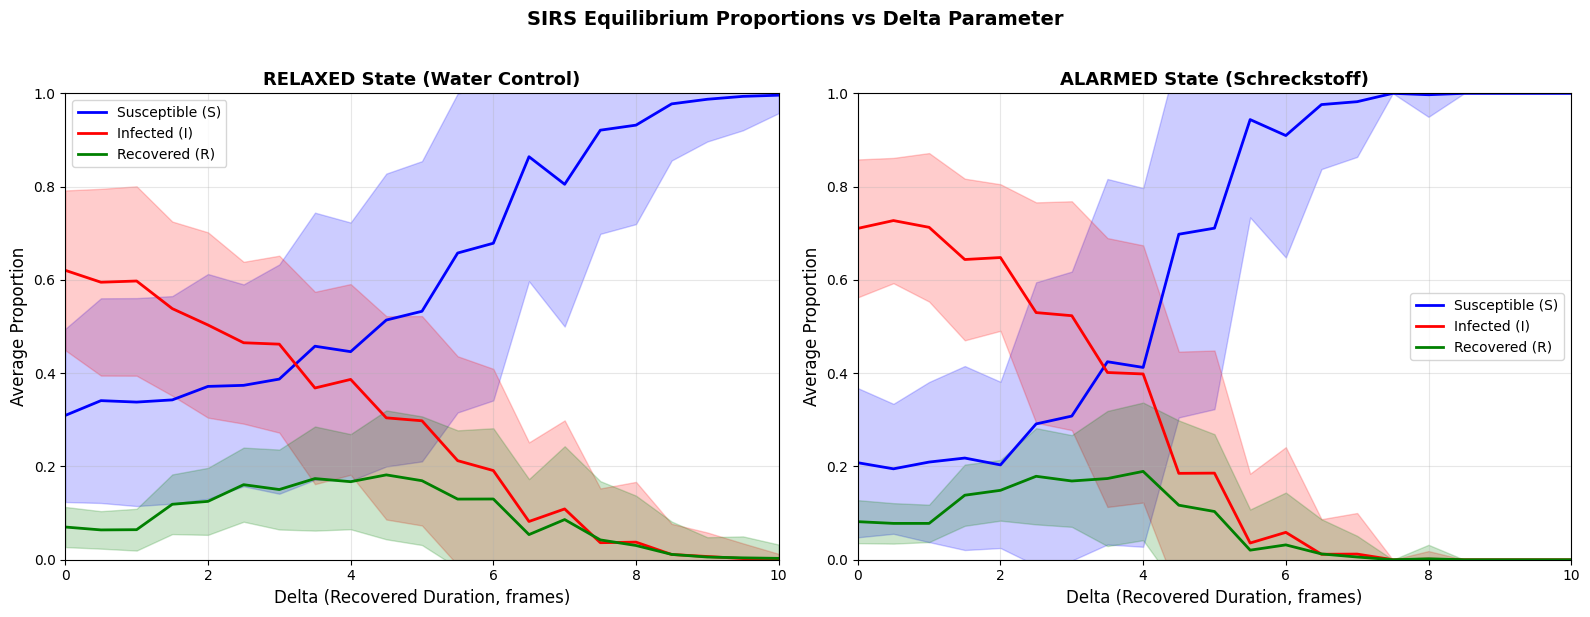

In [109]:
# Create side-by-side comparison plots for Relaxed vs Alarmed states
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: RELAXED state (water control - loose formation)
ax1.plot(delta_values, s_mean_relaxed, "b-", label="Susceptible (S)", linewidth=2)
ax1.plot(delta_values, i_mean_relaxed, "r-", label="Infected (I)", linewidth=2)
ax1.plot(delta_values, r_mean_relaxed, "g-", label="Recovered (R)", linewidth=2)
ax1.fill_between(
    delta_values,
    s_mean_relaxed - s_std_relaxed,
    s_mean_relaxed + s_std_relaxed,
    color="blue",
    alpha=0.2,
)
ax1.fill_between(
    delta_values,
    i_mean_relaxed - i_std_relaxed,
    i_mean_relaxed + i_std_relaxed,
    color="red",
    alpha=0.2,
)
ax1.fill_between(
    delta_values,
    r_mean_relaxed - r_std_relaxed,
    r_mean_relaxed + r_std_relaxed,
    color="green",
    alpha=0.2,
)
ax1.set_xlabel("Delta (Recovered Duration, frames)", fontsize=12)
ax1.set_ylabel("Average Proportion", fontsize=12)
ax1.set_title("RELAXED State (Water Control)", fontsize=13, fontweight="bold")
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(delta_values[0], delta_values[-1])
ax1.set_ylim(0, 1)

# Right plot: ALARMED state (schreckstoff - tight formation)
ax2.plot(delta_values, s_mean_alarmed, "b-", label="Susceptible (S)", linewidth=2)
ax2.plot(delta_values, i_mean_alarmed, "r-", label="Infected (I)", linewidth=2)
ax2.plot(delta_values, r_mean_alarmed, "g-", label="Recovered (R)", linewidth=2)
ax2.fill_between(
    delta_values,
    s_mean_alarmed - s_std_alarmed,
    s_mean_alarmed + s_std_alarmed,
    color="blue",
    alpha=0.2,
)
ax2.fill_between(
    delta_values,
    i_mean_alarmed - i_std_alarmed,
    i_mean_alarmed + i_std_alarmed,
    color="red",
    alpha=0.2,
)
ax2.fill_between(
    delta_values,
    r_mean_alarmed - r_std_alarmed,
    r_mean_alarmed + r_std_alarmed,
    color="green",
    alpha=0.2,
)
ax2.set_xlabel("Delta (Recovered Duration, frames)", fontsize=12)
ax2.set_ylabel("Average Proportion", fontsize=12)
ax2.set_title("ALARMED State (Schreckstoff)", fontsize=13, fontweight="bold")
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_xlim(delta_values[0], delta_values[-1])
ax2.set_ylim(0, 1)

plt.suptitle(
    "SIRS Equilibrium Proportions vs Delta Parameter",
    fontsize=14,
    fontweight="bold",
    y=1.02,
)
plt.tight_layout()
plt.show()

### Comparing Infected Proportions

This plot shows the mean relaxed vs. alarmed infected proportions at different $\delta$ values.
The shaded area is one standard deviation.

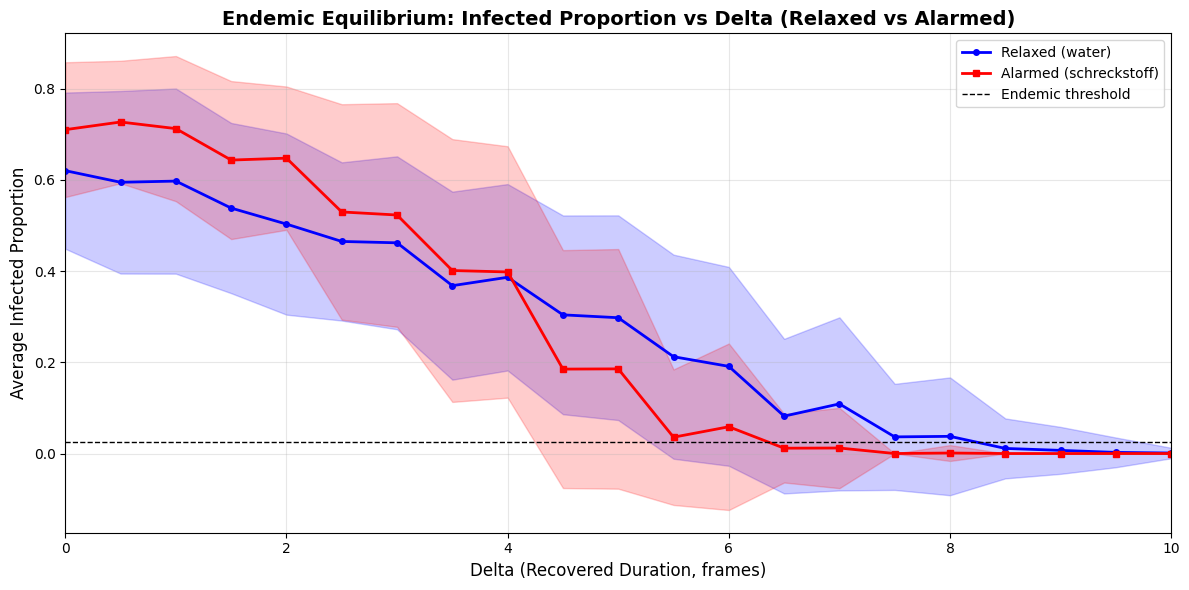

In [110]:
# Comparison: Infected proportion for Relaxed vs Alarmed states
plt.figure(figsize=(12, 6))

# Relaxed state (water control - loose formation)
plt.plot(
    delta_values,
    i_mean_relaxed,
    "b-",
    linewidth=2,
    marker="o",
    markersize=4,
    label="Relaxed (water)",
)
plt.fill_between(
    delta_values,
    i_mean_relaxed - i_std_relaxed,
    i_mean_relaxed + i_std_relaxed,
    color="blue",
    alpha=0.2,
)

# Alarmed state (schreckstoff - tight formation)
plt.plot(
    delta_values,
    i_mean_alarmed,
    "r-",
    linewidth=2,
    marker="s",
    markersize=4,
    label="Alarmed (schreckstoff)",
)
plt.fill_between(
    delta_values,
    i_mean_alarmed - i_std_alarmed,
    i_mean_alarmed + i_std_alarmed,
    color="red",
    alpha=0.2,
)

# Add horizontal line at endemic threshold (more than 1 fish infected out of 40)
plt.axhline(
    y=ENDEMIC_THRESHOLD,
    color="k",
    linestyle="--",
    linewidth=1,
    label="Endemic threshold",
)

plt.xlabel("Delta (Recovered Duration, frames)", fontsize=12)
plt.ylabel("Average Infected Proportion", fontsize=12)
plt.title(
    "Endemic Equilibrium: Infected Proportion vs Delta (Relaxed vs Alarmed)",
    fontsize=14,
    fontweight="bold",
)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.xlim(delta_values[0], delta_values[-1])

plt.tight_layout()
plt.show()